# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# matplotlib's pyplot for visualising losses and predictions of network
import matplotlib.pyplot as plt
# numpy for converting tensors to feed in to matplotlib
import numpy as np

# pytorch for all the deep learning magic
import torch
# nn module for neural network layers and optim module for optimizers
from torch import nn, optim
# torchvision's datasets for importing our dataset, models for pretrained convnets and transforms for preprocessing our dataset
from torchvision import datasets, models, transforms
# OrderedDict for specifying our network to nn.Sequential
from collections import OrderedDict
# time for timing things
import time
# json for importing json files
import json
# Image from Python Image Library for processing image file
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomPerspective(),
                                       transforms.RandomRotation(90),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224, scale=(0.15,1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(p=0.1), # in deployment we don't want the network to be useless if someone uploads an upside down picture!
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# DONE: Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
validset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
testset = datasets.ImageFolder(test_dir, transform=test_transforms)

# DONE: Using the image datasets and the trainforms, define the dataloaders
# define batch size as a variable to reuse later
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# DONE: Build and train your network
# Set model to a pretrained densenet161 convolutional NN. 
# This has a good balance between speed and accuracy.
model = models.densenet161(pretrained=True)
# model = models.vgg19_bn(pretrained=True)

# Check the architecture so we can match our classifier layers to the densenet network (correct tensor sizes)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [6]:
# freeze all the params of the pretrained network
for param in model.parameters():
    param.requires_grad = False

In [7]:
# commented out for project: improves accuracy on test set by 1% but doesn't meet rubric of static feature network!
# unfreeze the last block for finetuning
model.features.denseblock3.requires_grad = True
model.features.denseblock4.requires_grad = True
# check the last block has been unfrozen correctly
print(model.features.denseblock3.requires_grad)
print(model.features.denseblock4.requires_grad)

True
True


In [8]:
def use_device(gpu=True):
    """
    Accepts a bool and enables GPU respectively, if a CUDA-capable GPU is available.
    Parameters:
      gpu - bool for whether GPU acceleration should be enabled or not
    Returns:
      device - torch.device('cuda') if gpu is True and a CUDA-capable GPU is available, otherwise torch.device('cpu')
    """
    
    device = torch.device('cpu')
    
    if gpu == True:
        # use CUDA unless it's not available when sending tensors to 'device'
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    return device

In [9]:
def optimizer_first():
    """
    Checks torch version and if >=1.1.0 returns True. Fixes backward-compatibility of optim.lr_scheduler,
    i.e. optimizer.step() before scheduler.step() for versions >1.1.0.
    Parameters:
      None - simply using torch.__version__ to check torch version
    Returns:
      optimizer_first - bool, True if torch version is >=1.1.0, False if not
    """
    
    # get torch version
    torch_version = torch.__version__
    # check if version >1.1.0 (for scheduler/optimizer.step() order)
    optimizer_first = float(torch_version[0]) >= 1 and float(torch_version[2]) >= 1
    
    return optimizer_first

In [10]:
def build_classifier_dict(convnet, num_fc_layers, num_fc_neurons):
    """
    Returns an OrderedDict to be used with nn.Sequential to create the classifier of our network.
    Parameters:
      convnet - a string identifying the CNN architecture being used
      num_fc_layers - an int of the number of additional fully-connected layers to be used
      num_fc_neurons - an int of the number of neurons in each fully-connected layer
    Returns:
      classifier_dict - an OrderedDict describing the fully-connected layers, SELUs, AlphaDropout and LogSoftmax
    """
    
    classifier_dict = OrderedDict([])
    convnet_out = 1

    if convnet == 'densenet161':
        convnet_out = 2208
    elif convnet == 'vgg16':
        convnet_out = 25088
    else:
        print(f"WARNING: Network type of '{convnet}' was parsed for which the number of output neurons is unknown.\n\t Your network will not be built correctly.\n")

    classifier_dict['fc1'] = nn.Linear(convnet_out, num_fc_neurons)
    classifier_dict['selu1'] = nn.SELU()
    classifier_dict['dropout1'] = nn.AlphaDropout(p=0.5)

    for layer in range(num_fc_layers):
        classifier_dict['fc'+str(layer+2)] = nn.Linear(num_fc_neurons, num_fc_neurons)
        classifier_dict['selu'+str(layer+2)] = nn.SELU()
        classifier_dict['dropout'+str(layer+2)] = nn.AlphaDropout(p=0.5)

    classifier_dict['fc'+str(num_fc_layers+2)] = nn.Linear(num_fc_neurons, 102)
    classifier_dict['output'] = nn.LogSoftmax(dim=1)

    return classifier_dict

In [11]:
def classifier_setup(convnet, num_fc_layers=0, num_fc_neurons=4096, lr=0.001, epochs=100, gpu=True):
    """
    Returns device, criterion, optimizer and scheduler after setting up
    a classifier network to attach to our feature network.
    Parameters:
      convnet - a string identifying the CNN architecture being used
      num_fc_layers - an int of the number of additional fully-connected layers to be used
      num_fc_neurons - an int of the number of neurons in each fully-connected layer
    Returns:
      device - the torch device returned from the use_device() function call
      criterion - the loss function specified in this function
      optimizer - the optimizer specified in this function
      scheduler - the scheduler specified in this function
    """

    device = use_device(gpu)

    classifier_dict = build_classifier_dict(convnet, num_fc_layers, num_fc_neurons)

    # create our classifier network to bolt on behind the pretrained convnet
    classifier = nn.Sequential(classifier_dict)

    # change the pretrained model's classifier to our classifier
    model.classifier = classifier

    # send our model to the gpu if available and selected
    model.to(device)

    # set our loss function to Negative Log Likelihood Loss
    criterion = nn.NLLLoss()

    # set our optimizer and have it optimize only the classifier parameters (not those of the convnet)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # lr=0.0005 for Adam, 0.01 for SGD and momentum=0.9
    
    # scheduler patience
    patience = 25

    # when scheduler.step() comes before optimizer.step() (pre torch 1.1.0), multiply by len(trainloader)
    # so patience is still based on epochs (scheduler.step() gets called every batch before optimizer.step())
    if optimizer_first() == False:
        patience = patience * len(trainloader)

    # scheduler for LR decay
    # TODO: test LR schedule of ramping LR, plateau, then decrease, with momentum 0.95 -> 0.85 -> 0.95
    lmbda = lambda epoch: 1.08
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    
    return device, criterion, optimizer, scheduler

In [12]:
device, criterion, optimizer, scheduler = classifier_setup('densenet161', 0, 8192)

In [13]:
model.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=8192, bias=True)
  (selu1): SELU()
  (dropout1): AlphaDropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=8192, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [14]:
# training and validation
# get device to use
device = use_device()

# epochs completed (for resuming training)
epochs_completed = 0

# keep track of total time: training+validation
total_epoch_time = 0

# keep track of total training time
total_train_time = 0

# keep track of total validation time
total_valid_time = 0

# we'll use this later with modulo == 0 to report every this many steps
report_multiplier = 1
report_every = report_multiplier*len(trainloader) # report per report_multiplier number of epochs

In [15]:
def training(epochs_completed, report_every, total_epoch_time, total_train_time, total_valid_time, verbose=True):
    """
    Performs training on the training set and calls the validation function.
    Prints out the number of batches in training set when training begins.
    Prints the estimated time left for training the network.
    Parameters:
      epochs_completed - required to show correct number of epochs when resuming 
                         training of a network for additional epochs when this
                         function is called again.
      report_every - required for the function to know when to reset running_train_loss
                     and passed to validation() for statistics.
      total_epoch_time - required to correctly track total time training and validating
                         across multiple function calls.
      total_train_time - required to correctly track total time training across multiple
                         function calls.
      total_valid_time - required to correctly track total time validating across multiple
                         function calls.
    Returns:
      epochs_completed - total number of epochs completed
      total_epoch_time - total time training and validating
      total_train_time - total time training
      total_valid_time - total time validating
      
    """
    # number of training epochs
    epochs = 100
    # total epochs to do
    total_epochs = epochs_completed + epochs

    # steps we've taken (for reporting loss per x steps)
    steps = 0
    # our running loss
    running_train_loss = 0

    print(f'Number of batches in training set: {len(trainloader)}...')
    # main training loop
    for epoch in range(epochs):
        epoch_time = 0
        train_time = 0
        valid_time = 0
        start = time.time()
        # loop over our batches in trainloader
        for inputs, labels in trainloader:
            # increment steps
            steps += 1
        
            # send inputs and labels to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
        
            # zero our gradients so they don't accumulate across batches
            optimizer.zero_grad()
        
            # get our log probabilities from forward pass through the network
            logps = model.forward(inputs)
            # calculate our training loss for this batch
            train_loss = criterion(logps, labels)
            # add the loss for this training batch to the running training loss
            running_train_loss += train_loss.item()
            # propagate the error backward through the network
            train_loss.backward()
            # if pytorch version <1.1.0, call scheduler here
            if optimizer_first() == False:
                scheduler.step()
            # take an optimizer step in the direction of the gradients multiplied by the learning rate
            optimizer.step()
            
            # we'll report every 'report_every' number of batches
            if steps % report_every == 0:
                valid_time = validation(running_train_loss, report_every, total_epochs, epochs_completed, verbose)
                running_train_loss = 0
            
        epoch_time = time.time() - start
        total_epoch_time += epoch_time
        
        total_valid_time += valid_time
        
        train_time = epoch_time - valid_time
        total_train_time += train_time
        
        epochs_completed += 1
        
        if verbose:
            print(f'\nEpoch {epochs_completed} took: {epoch_time:.3f} seconds')
            print(f'\n{(train_time/epoch_time)*100:.1f}% of the time was spent on training.\n'
                    f'{(valid_time/epoch_time)*100:.1f}% of the time was spent on validation.\n'
                    f'\nTraining/validating for: {total_epoch_time:.2f} seconds this session...')
        print(f'Estimated time left: {(total_epoch_time/(epoch+1))*(epochs-(epoch+1)):.2f} seconds...\n')
        
        
    return epochs_completed, total_epoch_time, total_train_time, total_valid_time

In [22]:
def validation(running_train_loss, report_every, total_epochs, epochs_completed, verbose):
    """
    Performs validation on the validation set. Called in the training() function.
    Prints out the current epoch, training loss, validation loss and validation accuracy.
    Parameters:
      running_train_loss - required to calculate the training loss
      report_every - required to calculate training loss
      total_epochs - required to show the correct number of epochs denominator
      epochs_completed - required to show the current epoch
      verbose - when True, function shows duration of current validation
    Returns:
      valid_time - the duration of the validation pass
    """
    valid_time = 0
    valid_start = time.time()
    # create running_valid_loss and accuracy within the scope of this
    running_valid_loss = 0
    accuracy = 0
    # set the model to evaluation mode to disable dropout
    model.eval()
    # stop tracking gradients for a speedup since we're not doing backprop here
    with torch.no_grad():
        # loop over our batches in validloader
        for inputs, labels in validloader:
            # send inputs and labels to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            # get log probabilities from a forward pass through the network
            logps = model.forward(inputs)
            # calculate the validation loss for this batch
            valid_loss = criterion(logps, labels)
                    
            # add the loss for this validation batch to the running validation loss
            running_valid_loss += valid_loss.item()
                    
            # calculate the accuracy for this batch
            # probabilities from log probabilities
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            # if top_class and label matches set equals to True
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()            
    # scheduler here for newer versions of pytorch so patience can be based on validation rather
    # than training if wanted
    
    current_lr = current_lr()
        
    if optimizer_first() == True:
        scheduler.step()
            
    valid_time = time.time() - valid_start
    if verbose:
        print(f'\nDuration of this validation: {valid_time:.3f} seconds...')
            
    print(f'\nThis epoch\'s learning rate: {current_lr}'
          f'\nEpoch {1+epochs_completed}/{total_epochs}... '
          f'Train loss: {running_train_loss/report_every:.3f}... '
          f'Validation loss: {running_valid_loss/len(validloader):.3f}... '
          f'Validation accuracy: {accuracy/len(validloader):.3f}...')
            
    model.train()
    
    return valid_time

In [23]:
# TODO: see if this can be used for betas with AdamW optimizer,
# then use 1cycle learning and modifying beta1 from 
# 0.95 -> 0.85 -> 0.95 through training
def current_lr():
    """
    Returns the current learning rate after finding it in optimizer.param_groups
    Parameters:
      None
    Returns:
      None
    """
    current_lr = 0
    
    for g in optimizer.param_groups:
        current_lr = g['lr']
        
    return current_lr

0.001


In [24]:
# TODO: log the training loss and epoch then plot it with matplotlib
# TODO: CHALLENGE: make training(), validation(), testing() all part of a class called network_learning()
epochs_completed, total_epoch_time, total_train_time, total_valid_time = training(epochs_completed, report_every, 
                                                                                  total_epoch_time, total_train_time, 
                                                                                  total_valid_time, verbose=True)

Number of batches in training set: 52...

Duration of this validation: 7.591 seconds...

Epoch 1/100... Train loss: 4.609... Validation loss: 4.345... Validation accuracy: 0.056...
Current learning rate: 0.00108

Epoch 1 took: 136.676 seconds

94.4% of the time was spent on training.
5.6% of the time was spent on validation.

Training/validating for: 136.68 seconds this session...
Estimated time left: 13530.88 seconds...


Duration of this validation: 7.696 seconds...

Epoch 2/100... Train loss: 4.386... Validation loss: 4.041... Validation accuracy: 0.140...
Current learning rate: 0.0011664000000000002

Epoch 2 took: 135.128 seconds

94.3% of the time was spent on training.
5.7% of the time was spent on validation.

Training/validating for: 271.80 seconds this session...
Estimated time left: 13318.39 seconds...


Duration of this validation: 7.766 seconds...

Epoch 3/100... Train loss: 4.209... Validation loss: 3.644... Validation accuracy: 0.216...
Current learning rate: 0.0012597120

In [18]:
print(f'Epochs completed: {epochs_completed}\n'
      f'Total time training/validating: {total_epoch_time:.2f}\n'
      f'Total time training: {total_train_time:.2f}\n'
      f'Total time validating: {total_valid_time:.2f}\n')

Epochs completed: 50
Total time training/validating: 5609.23
Total time training: 5064.52
Total time validating: 544.71



## Learning rate results for 1cycle policy:

##### Weight Decay: 0.1
Learning rate and corresponding training loss after 25 epochs (avg of last 3):
- 0.01: 7.95
- 0.003:

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:
# DONE: Do testing on the test set
def testing():
    """
    Performs testing on the test set and prints out the test loss and test accuracy.
    Parameters:
      None
    Returns:
      test_loss_achieved
      test_accuracy_achieved
    """
    running_test_loss = 0
    accuracy = 0

    # set our model to evaluation mode
    model.eval()

    # execute code without gradient calculations
    with torch.no_grad():
        for inputs, labels in testloader:
            # send inputs and labels to gpu if available
            inputs, labels = inputs.to(device), labels.to(device)
        
            # get log probabilities from forward pass through network
            logps = model.forward(inputs)
            # get loss
            test_loss = criterion(logps, labels)
        
            # add the loss for this batch to the running test loss
            running_test_loss += test_loss.item()
        
            # calculate the accuracy for this batch
            # convert log probabilities to probabilities
            ps = torch.exp(logps)
            # get top probability and top class with topk
            top_p, top_class = ps.topk(1, dim=1)
            # if top class and label match, set equals to True
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    test_loss_achieved = running_test_loss/len(testloader)
    test_accuracy_achieved = accuracy/len(testloader)
        
    print(f'Test loss: {test_loss_achieved:.3f}...'
          f'Test accuracy: {test_accuracy_achieved:.3f}...')

    running_test_loss = 0
    model.train()
    
    return test_loss_achieved, test_accuracy_achieved

In [20]:
test_loss_achieved, test_accuracy_achieved = testing()

Test loss: 0.182...Test accuracy: 0.972...


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# DONE: Save the checkpoint
image_datasets = {'train': trainset, 'valid': validset, 'test': testset}
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'input_size': 2208,
              'output_size': 102,
              'batch_size': batch_size,
              'model': models.densenet161(pretrained=True),
              'classifier': model.classifier,
              'epochs_completed': epochs_completed,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'class_to_idx': model.class_to_idx,
              'test_loss': test_loss_achieved,
              'test_accuracy': test_accuracy_achieved}

torch.save(checkpoint, 'checkpoint_densenet_161_50_epochs_sgd_3layer_8192_selu.pth')

In [22]:
checkpoint = torch.load('checkpoint_densenet_161_50_epochs_sgd_3layer_8192_selu.pth')

### Tests:
#### DenseNet-201 achieved: 
##### Test loss: 0.135, Test accuracy: 0.962, with:
- RandomPerspective(), RandomRotation(30), Resize(255), RandomCrop(224), RandomHorizontalFlip()
- Training loss became much lower than validation loss. Add more data augmentation.

##### Test loss: 0.159, Test accuracy: 0.955, with:
- RandomPerspective(), RandomRotation(45), Resize(255), RandomResizedCrop(224, scale=(0.25, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Training loss didn't decrease far below validation loss and validation accuracy was consistently higher. Unexpected result!
- Increase FC layers to accomodate greater translational invariance?

##### Test loss: 0.238, Test accuracy: 0.94, with 50 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Loss still decreasing, need to increase epochs. Aggressive RandomResizedCrop forces network to infer which flower is present, even if flower is not present
  in the crop, by the other plants growing around it etc.

##### Test loss: 0.172, Test accuracy: 0.964, with 200 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Best so far.

#### DenseNet-161 achieved:
##### Test loss: 0.120, Test accuracy: 0.971, with 200 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)

##### Test loss: 0.126, Test accuracy: 0.967, with 200 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Classifier layers made smaller to 4096 neurons each instead of 8192

##### Test loss: 0.126, Test accuracy: 0.974, with 200 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Still three FC classifier layers with 4096 neurons each
- Dropout reduced to 0.2
- Batch Normalization added after ReLU

##### Test loss: 0.681, Test accuracy: 0.975, with 400 epochs (4 layers took longer to train) and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Four FC classifier layers with 4096 neurons each
- SELU activations
- AlphaDropout 0.5

##### Test loss: 0.279, Test accuracy: 0.984, with 200 epochs and:
- RandomPerspective(), RandomRotation(90), Resize(255), RandomResizedCrop(224, scale=(0.15, 1.0)), RandomHorizontalFlip(), RandomVerticalFlip(p=0.1)
- Three FC classifier layers with 8192 neurons each
- SELU activations
- AlphaDropout 0.5
- Last Denseblock (denseblock4) unfrozen for finetuning

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [23]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def rebuild_model(checkpoint, frozen_features=True):
    """
    Accepts a path to a checkpoint file and returns a network.
    """
    # use CUDA unless it's not available when sending tensors to 'device'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoint = torch.load(checkpoint)
    model = checkpoint['model']
    
    if frozen_features:
        for param in model.parameters():
            param.requires_grad = False
        print(f"Model loaded and features frozen.\n")
    else: 
        print(f"Model loaded with unfrozen features.\n"
              f"WARNING: The feature detection network will also be trained!\n")
    
    model.classifier = checkpoint['classifier']
    print(f"Pre-trained ConvNet classifier replaced with classifier trained for flower classification.\n"
          f"This classifier has been trained for {checkpoint['epochs_completed']} epochs and achieves:\n"
          f"Test loss: {checkpoint['test_loss']:.3f}.. "
          f"Test accuracy: {checkpoint['test_accuracy']:.3f}\n")
    
    model.to(device)
    
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True, factor=0.5)
    
    for word, word_string in zip((model, optimizer, scheduler), ('model', 'optimizer', 'scheduler')):
        word.load_state_dict(checkpoint[word_string+'_state_dict'])
        print(f"{word_string.capitalize()} state dict loaded!")

    model.class_to_idx = checkpoint['class_to_idx']
    print(f"Model class to index loaded!\n")
    
    epochs_completed = checkpoint['epochs_completed']
    
    
    return model, criterion, optimizer, scheduler

In [24]:
model, criterion, optimizer, scheduler = rebuild_model('checkpoint_densenet_161_50_epochs_sgd_3layer_8192_selu.pth', frozen_features=True);

Model loaded and features frozen.

Pre-trained ConvNet classifier replaced with classifier trained for flower classification.
This classifier has been trained for 50 epochs and achieves:
Test loss: 0.182.. Test accuracy: 0.972

Model state dict loaded!
Optimizer state dict loaded!
Scheduler state dict loaded!
Model class to index loaded!



In [25]:
model.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=8192, bias=True)
  (selu1): SELU()
  (dropout1): AlphaDropout(p=0.5)
  (fc2): Linear(in_features=8192, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [26]:
def process_image(image, width=256, height=256, sanity_check=False, debug=False):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # DONE: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    img = img.resize((width, height))
    
    crop_width = 224 
    crop_height = 224
    left = (width - crop_width)/2 
    right = crop_width + left
    top = (height - crop_height)/2
    bottom = crop_height + top
    
    img = img.crop((left, top, right, bottom))
    
    if sanity_check == False:
        img = np.array(img)
    
        img = np.divide(img, 255)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = (img - mean)/std
    
        img = img.transpose((-1, 0, 1))
        
        # check dimensions are correct (change crop width or height above to be sure of their order)
        if debug == True:
            print(img.shape)
    
    return img
    
    

In [27]:
img_path = 'flowers/test/1/image_06743.jpg'

In [28]:
process_image(img_path)

array([[[-2.01515541, -1.89528213, -1.72403459, ..., -1.55278705,
         -1.12466821, -1.07329395],
        [-1.82678311, -1.7582841 , -1.7582841 , ..., -1.91240688,
         -2.01515541, -1.87815738],
        [-1.68978508, -1.72403459, -1.84390787, ..., -1.87815738,
         -1.77540885, -1.63841082],
        ...,
        [-1.3130405 , -1.33016525, -1.38153952, ..., -1.48428804,
         -1.50141279, -1.5356623 ],
        [-1.38153952, -1.45003853, -1.36441476, ..., -1.62128607,
         -1.62128607, -1.60416132],
        [-1.56991181, -1.62128607, -1.72403459, ..., -1.63841082,
         -1.62128607, -1.63841082]],

       [[-1.80812325, -1.68557423, -1.54551821, ..., -1.19537815,
         -0.67016807, -0.61764706],
        [-1.61554622, -1.54551821, -1.58053221, ..., -1.70308123,
         -1.68557423, -1.54551821],
        [-1.4754902 , -1.5105042 , -1.66806723, ..., -1.72058824,
         -1.5105042 , -1.33543417],
        ...,
        [-0.93277311, -0.91526611, -0.91526611, ..., -

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [29]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [30]:
img_path = 'flowers/test/1/image_06743.jpg'

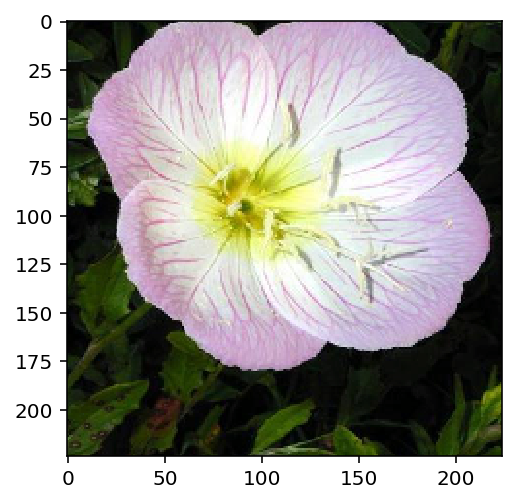

In [31]:
imshow(process_image(img_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [32]:
def predict(image_path, checkpoint, topk=5, device=use_device(), debug=False):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model, criterion, optimizer, scheduler = rebuild_model(checkpoint, frozen_features=True)
    model.eval()    
    
    img = process_image(image_path)
    img = torch.from_numpy(img).float().to(device)
    # PyTorch expects a batch dimension: add this dimension and set to 1 for a single image
    img = img.view(1, 3, 224, 224).float()
    if debug == True:
        print(img)
    logps = model.forward(img)
    ps = torch.exp(logps)
    
    top_ps, top_idxs = ps.topk(topk, dim=1)
    
    class_to_idx = model.class_to_idx
    idx_to_class = dict(map(reversed, class_to_idx.items()))
    
    if debug == True:
        print(f"Indices to classes:\n {idx_to_class}")
    
    top_classes = []
    
    model.train()
    
    if debug == True:
        print(f"Top probabilities (tensor):\n {top_ps}\nTop indices (tensor):\n {top_idxs}")
    
    # move top idxs to cpu and convert to numpy
    top_idxs = top_idxs.to('cpu').numpy()
    top_ps = top_ps.to('cpu').detach().numpy()
    
    top_ps = top_ps[0]
    
    if debug == True:
        print(f"Top indices (numpy):\n {top_idxs}")
    
    for idx in top_idxs[0]:
        top_classes.append(idx_to_class[idx])
    
    return top_ps, top_classes   
    

In [33]:
probs, classes = predict("flowers/test/1/image_06743.jpg", "checkpoint_densenet_161_50_epochs_sgd_3layer_8192_selu.pth")
print(f"Top probabilities are:\n {probs}")
print(f"Top classes are:\n {classes}")

Model loaded and features frozen.

Pre-trained ConvNet classifier replaced with classifier trained for flower classification.
This classifier has been trained for 50 epochs and achieves:
Test loss: 0.182.. Test accuracy: 0.972

Model state dict loaded!
Optimizer state dict loaded!
Scheduler state dict loaded!
Model class to index loaded!

Top probabilities are:
 [9.8796326e-01 1.2013682e-02 2.2211869e-05 8.8270248e-08 4.0707352e-08]
Top classes are:
 ['1', '76', '86', '83', '19']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [34]:
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [35]:
# DONE: Display an image along with the top 5 classes
def sanity_check(image_path, checkpoint, debug=False):
    """
    Displays image along with the 5 top class predictions.
    Parameters:
      image_path - path to the image to be classified
      checkpoint - the checkpoint file for the network to be used
      debug - if True, top_flowers list is displayed
    """
    # Resize to 256x256 then crop to 224x224
    img = process_image(image_path, sanity_check=True)
    
    # Get top probabilties and top classes
    top_probs, top_classes = predict(image_path, checkpoint)
    
    top_flowers = []
    
    for top_class in top_classes:
        top_flowers.append(cat_to_name[top_class])
    if debug == True:
        print(f"The top flowers are:\n {top_flowers}")
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5,10))
    ax1.set_title(top_flowers[0])    
    ax1.imshow(img)
    ax2.set_title("Flower prediction probabilities")
    ax2.barh(np.arange(len(top_probs)), top_probs)
    ax2.set_yticks(np.arange(len(top_flowers)))
    ax2.set_yticklabels(top_flowers)
    ax2.invert_yaxis()

In [36]:
# before finetuning sweet peas were problematic for the network, with finetuning
# it correctly identifies all in the test set bar one!
#img_path = 'flowers/test/4/image_05653.jpg'

# picture of dandelion in our garden
img_path = 'dandelion.jpg'

Model loaded and features frozen.

Pre-trained ConvNet classifier replaced with classifier trained for flower classification.
This classifier has been trained for 50 epochs and achieves:
Test loss: 0.182.. Test accuracy: 0.972

Model state dict loaded!
Optimizer state dict loaded!
Scheduler state dict loaded!
Model class to index loaded!



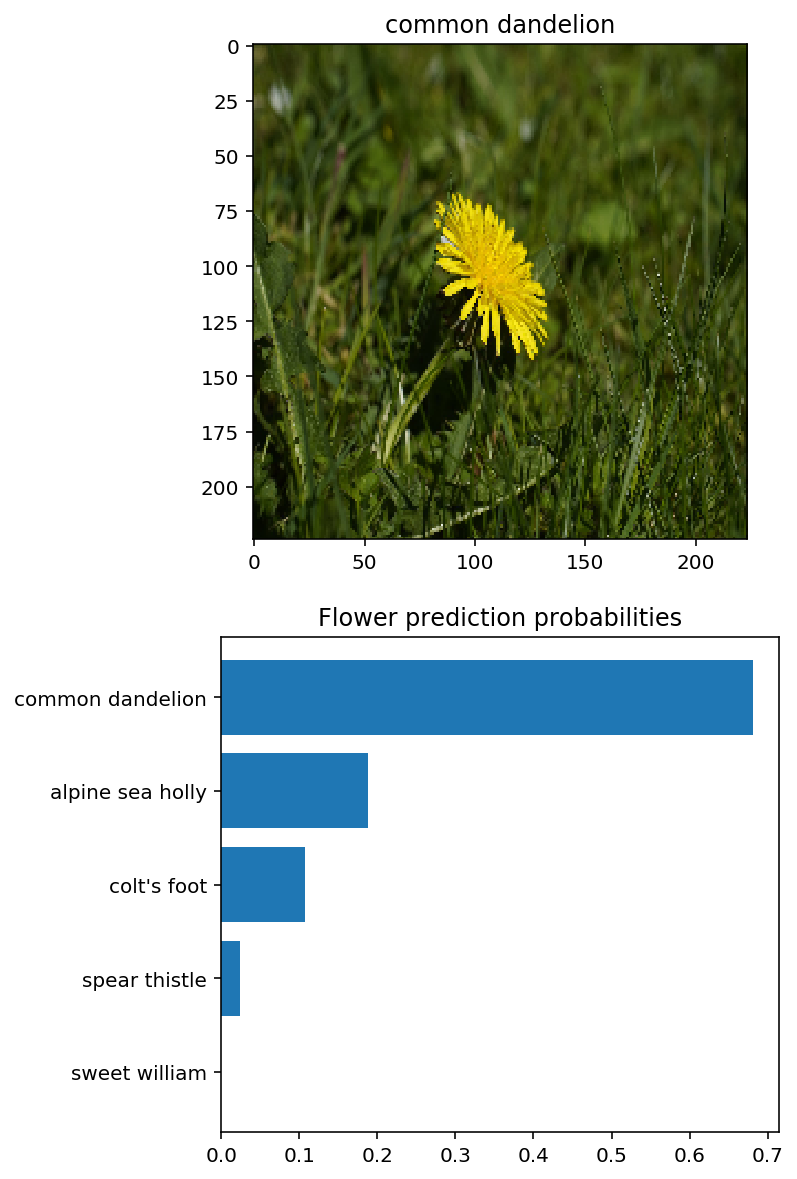

In [37]:
sanity_check(img_path, "checkpoint_densenet_161_50_epochs_sgd_3layer_8192_selu.pth")